# Music or Speech: Classification with RNN

## Modules and Helpers

In [1]:
colab = True # set to True is using google colab

if colab:
    %tensorflow_version 2.x
#mount google drive when on google colab and set working directory

import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/music_speech/')

working_dir = os.getcwd()
print(f'\nWorking directory: {working_dir}')




Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Mounted at /content/drive

Working directory: /content/drive/MyDrive/music_speech


In [2]:
#initialize environment, load modules/libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import time
import random

#Helpers

from scipy.signal import hann
from scipy.io import wavfile
	
def get_mag_phs(re_im):
    mag_phs=[]
    for c in re_im:
        re=c[0]
        im=c[1]
        mag_phs.append([np.sqrt(re**2 + im**2), np.angle(re + im * 1j)])
    return np.array(mag_phs)


def get_logmag(re_im):
    logmag=[]
    for c in re_im:
        re=c[0]
        im=c[1]
        logmag.append(np.log(np.sqrt(re**2 + im**2)))
    return np.array(logmag)


def get_re_im(mag_phs):
    re_im=[]
    for c in mag_phs:
        mag=c[0]
        phs=c[1]
        re_im.append([mag * np.cos(phs), mag * np.sin(phs)])
    return np.array(re_im)


def load_wav(filenames):
    wl=[]
    for name in filenames:
        _, w = wavfile.read(name)
        w = w.astype(np.float32)
        norm = np.max(np.abs(w))
        w = w / norm
        w -= np.mean(w)
        wl.append(w)
    return np.array(wl)


def dft(sounds, fft_chunks, fft_step=256, fft_size=512):
    #fft_chunks = len(sounds[0]) // fft_step
    hann_win = hann(fft_size)
    re_im = []
    for signal in sounds:
        s = []
        for i in range(fft_chunks):
            frame = signal[(i * fft_step):(i * fft_step + fft_size)]
            frame = np.pad(frame, (0, fft_size - len(frame)), 'constant')
            frame *= hann_win
            s.append(frame)
        s = np.array(s)
        N = s.shape[-1]
        k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [1, N // 2])
        x = np.reshape(np.linspace(0.0, N - 1, N), [N, 1])
        freqs = np.dot(x, k)
        reals = np.dot(s, np.cos(freqs)) * (2.0 / N)
        imags = np.dot(s, np.sin(freqs)) * (2.0 / N)
        re_im.append([reals,imags])
    return np.array(re_im)


def dft_logmag(sounds, fft_chunks, fft_step=256, fft_size=512):
    re_im = dft(sounds, fft_chunks, fft_step, fft_size)
    return get_logmag(re_im)


def patches(sounds, patch_step, patch_size):
    num_sounds, num_samples, num_frequencies = sounds.shape
    num_patches = ((num_samples - patch_size) // patch_step)+1
    p = np.zeros((num_sounds,num_patches,patch_size,num_frequencies))
    for i in range(num_sounds):
        for j in range(num_patches):
            p[i,j,:,:] = sounds[i,(j*patch_step):(j*patch_step+patch_size),:]
    return p


def idft(re, im, step_size=256, fft_size=512):
	N = re.shape[1] * 2
	k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [N // 2, 1])
	x = np.reshape(np.linspace(0.0, N - 1, N), [1, N])
	freqs = np.dot(k, x)
	signal = np.zeros((re.shape[0] * step_size + fft_size,))
	recon = np.dot(re, np.cos(freqs)) + np.dot(im, np.sin(freqs))
	for hop_i, frame in enumerate(recon):
		signal[(hop_i * step_size): (hop_i * step_size + fft_size)] += frame
	return signal

## Data Preparation

### Loading Data

In [3]:
music_dir = './data/music_wav'
if not os.path.isdir(music_dir): 
    print(f'copy folder "music_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

music_test = [
    'unpoco.wav',
    'blues.wav',
    'gismonti.wav',
    'ipanema.wav',
    'deedee.wav',
    'hendrix.wav',
    'madradeus.wav',
    'marlene.wav',
    'beatles.wav',
    'bagpipe.wav',
    'redhot.wav',
    'jazz.wav'
]
music_test = [os.path.join(music_dir, file) for file in music_test]

music = [os.path.join(music_dir, file) for file in os.listdir(music_dir) if file.endswith('.wav')]
music = list(set(music)-set(music_test))

speech_dir = './data/speech_wav'
if not os.path.isdir(speech_dir): 
    print(f'copy folder "speech_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

speech_test = [
    'comedy.wav',
    'thlui.wav',
    'voices.wav',
    'conversion.wav',
    'china.wav',
    'vegetables2.wav',
    'amal.wav',
    'teachers2.wav',
    'chant.wav',
    'pulp2.wav',
    'acomic.wav',
    'kid.wav'
]
speech_test = [os.path.join(speech_dir, file) for file in speech_test]

speech = [os.path.join(speech_dir, file) for file in os.listdir(speech_dir) if file.endswith('.wav')]
speech = list(set(speech)-set(speech_test))
	  
print (len(music), len(speech))

52 52


### Split Data

In [4]:
test = speech_test + music_test
test_labels = np.zeros(len(test))
test_labels[0:len(speech_test)]=1

split = len(speech)*8//10

train = speech[:split] + music[:split]
train_labels = np.zeros(len(train))
train_labels[:split]=1

validate = speech[split:] + music[split:]
validate_labels = np.zeros(len(validate))
validate_labels[:len(speech[split:])]=1

def permute(data, labels):
    p = list(zip(data,labels))
    random.shuffle(p)
    data, labels = zip(*p)
    return data, labels

test, test_labels = permute(test, test_labels)
train, train_labels = permute(train, train_labels)
validate, validate_labels = permute(validate, validate_labels)

print("Number of sounds (music and speech)")
print(f"- Test: {len(test)}")
print(f"- Validation: {len(validate)}")
print(f"- Training: {len(train)}")



Number of sounds (music and speech)
- Test: 24
- Validation: 22
- Training: 82


Raw Visualization 

In [5]:
test_sounds = load_wav(test)
train_sounds = load_wav(train)
validate_sounds = load_wav(validate)
print(train)
print(train_labels)

('./data/speech_wav/acomic2.wav', './data/music_wav/glass1.wav', './data/music_wav/duke.wav', './data/music_wav/rock.wav', './data/speech_wav/austria.wav', './data/speech_wav/emil.wav', './data/music_wav/cure.wav', './data/music_wav/moanin.wav', './data/speech_wav/pulp.wav', './data/speech_wav/pulp1.wav', './data/speech_wav/fem_rock.wav', './data/music_wav/caravan.wav', './data/music_wav/ncherry.wav', './data/speech_wav/undergrad.wav', './data/speech_wav/teachers1.wav', './data/speech_wav/vegetables.wav', './data/music_wav/opera1.wav', './data/music_wav/jazz1.wav', './data/speech_wav/fire.wav', './data/speech_wav/serbian.wav', './data/speech_wav/nj105.wav', './data/speech_wav/smoking.wav', './data/music_wav/debussy.wav', './data/music_wav/chaka.wav', './data/speech_wav/ellhnika.wav', './data/music_wav/prodigy.wav', './data/speech_wav/georg.wav', './data/music_wav/beat.wav', './data/speech_wav/sleep.wav', './data/speech_wav/india.wav', './data/music_wav/russo.wav', './data/music_wav/win

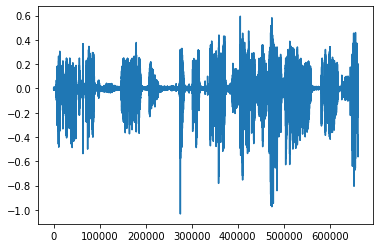

In [6]:
plt.plot(train_sounds[0])
plt.show()

### Fourier Transformation for Spectrograms

In [7]:
fft_step=256
fft_size=512
fft_chunks = len(train_sounds[0])//fft_step

test_logmag = dft_logmag(test_sounds,fft_chunks,fft_step,fft_size)
train_logmag = dft_logmag(train_sounds,fft_chunks,fft_step,fft_size)
validate_logmag = dft_logmag(validate_sounds,fft_chunks,fft_step,fft_size)
print(train_logmag.shape)
print(f"- Test: {test_logmag.shape}")
print(f"- Validation: {validate_logmag.shape}")
print(f"- Training: {train_logmag.shape}")
#print(train_logmag)

(82, 2583, 256)
- Test: (24, 2583, 256)
- Validation: (22, 2583, 256)
- Training: (82, 2583, 256)


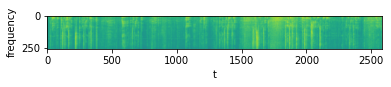

In [8]:
plt.imshow(train_logmag[0].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

### Patch Creation

In [22]:
patch_step = 1
patch_size = 15

n_timesteps, n_feature = train_logmag[0].shape

def ds_window(sound, label):
    #labels = np.array(range(len(sound)))
    #sound = np.c_[sound,labels]
    labels = np.ones(n_timesteps)*label
    sound = np.c_[sound,labels]
    #ds = tf.expand_dims(sound, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(sound)
    ds = ds.window(size=patch_size,shift=patch_step,drop_remainder=True)
    return ds

def ds_patches(sounds, labels):
    ds = ds_window(sounds[0],labels[0])
    for sound, label in zip(sounds[1:],labels[1:]): ds = ds.concatenate(ds_window(sound,label))
    ds = ds.flat_map(lambda x: x.batch(patch_size))
    ds = ds.map(lambda x: (x[:patch_size,:-1], x[0,-1]))
    return ds.batch(1)

test_ds = ds_patches(test_logmag, test_labels)
train_ds = ds_patches(train_logmag, train_labels)
validate_ds = ds_patches(validate_logmag, validate_labels)

n_chunks = ((test_logmag.shape[1]-patch_size)//patch_step)+1
n_test = test_logmag.shape[0]*n_chunks
n_train = train_logmag.shape[0]*n_chunks
n_validate = validate_logmag.shape[0]*n_chunks

print(f"{train_ds}\n")
print("Total number of chunks")
print(f"- Test: {n_test}")
print(f"- Validation: {n_validate}")
print(f"- Training: {n_train}")
print(f"- chunks: {n_chunks}")
print(f"- timesteps: {n_timesteps}")
print(f"- features: {n_feature}")

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 256), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

Total number of chunks
- Test: 61656
- Validation: 56518
- Training: 210658
- chunks: 2569
- timesteps: 2583
- features: 256


Visualization / Checks

In [10]:
for sound, label in train_ds.take(1):
    print(sound.numpy().shape)
    print(label.numpy().shape)

(1, 30, 256)
(1,)


In [11]:
n = 10
for sound, label in train_ds.take(n):
    sound = sound.numpy()[0]
    print(f"{sound.shape} : {sound[[0,patch_step],0]} : {sound[[-patch_step-1,-1],0]} : {label}") #

(30, 256) : [-5.86857599 -6.32609498] : [-5.15098363 -5.49420681] : [1.]
(30, 256) : [-6.32609498 -7.47436186] : [-5.49420681 -5.1286224 ] : [1.]
(30, 256) : [-7.47436186 -5.69240857] : [-5.1286224  -5.25384013] : [1.]
(30, 256) : [-5.69240857 -5.83719494] : [-5.25384013 -5.57335356] : [1.]
(30, 256) : [-5.83719494 -9.07944111] : [-5.57335356 -5.26540199] : [1.]
(30, 256) : [-9.07944111 -7.01108782] : [-5.26540199 -5.20411327] : [1.]
(30, 256) : [-7.01108782 -6.12927898] : [-5.20411327 -5.96707209] : [1.]
(30, 256) : [-6.12927898 -6.17896247] : [-5.96707209 -5.89269325] : [1.]
(30, 256) : [-6.17896247 -6.7526661 ] : [-5.89269325 -5.10403751] : [1.]
(30, 256) : [-6.7526661 -6.6168534] : [-5.10403751 -5.36131077] : [1.]


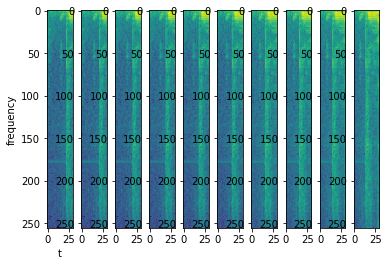

In [12]:
for i, (sound, label) in enumerate(train_ds.take(n)):
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy().T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
plt.show()

### Shuffling

In [23]:
train_ds = train_ds.shuffle(5*n_chunks).prefetch(1)
validate_ds = validate_ds.shuffle(5*n_chunks).prefetch(1)
test_ds = test_ds.shuffle(5*n_chunks).prefetch(1)

## Model & Training

### Model

In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256,input_shape=(patch_size,n_feature))) 
model.add(tf.keras.layers.Dropout(0.2)) 
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000005)

    
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)               

### Training

In [25]:
history = model.fit(train_ds, validation_data=validate_ds, epochs=50, steps_per_epoch = 500, batch_size = 50, validation_steps = 500, verbose=1) 

Epoch 1/50
500/500 [==============================] - 14s 16ms/step - loss: 0.6647 - accuracy: 0.5820 - val_loss: 0.7068 - val_accuracy: 0.5240
Epoch 2/50
500/500 [==============================] - 6s 12ms/step - loss: 0.6382 - accuracy: 0.6360 - val_loss: 0.7221 - val_accuracy: 0.5200
Epoch 3/50
500/500 [==============================] - 7s 14ms/step - loss: 0.5979 - accuracy: 0.6860 - val_loss: 0.7054 - val_accuracy: 0.6000
Epoch 4/50
500/500 [==============================] - 6s 11ms/step - loss: 0.5322 - accuracy: 0.7780 - val_loss: 0.6961 - val_accuracy: 0.6060
Epoch 5/50
500/500 [==============================] - 9s 17ms/step - loss: 0.4520 - accuracy: 0.8520 - val_loss: 0.7273 - val_accuracy: 0.6180
Epoch 6/50
500/500 [==============================] - 6s 12ms/step - loss: 0.3666 - accuracy: 0.9220 - val_loss: 0.8153 - val_accuracy: 0.6020
Epoch 7/50
500/500 [==============================] - 7s 15ms/step - loss: 0.3243 - accuracy: 0.9040 - val_loss: 0.9008 - val_accuracy: 0.562

In [16]:
#model.predict(test_ds.take(30))

### Results

In [17]:
model.evaluate(train_ds.take(5000))

5000/5000 [==============================] - 23s 4ms/step - loss: 0.2995 - accuracy: 0.9586


[0.2994937002658844, 0.9585999846458435]

In [18]:
model.evaluate(validate_ds.take(5000))

5000/5000 [==============================] - 21s 4ms/step - loss: 0.8332 - accuracy: 0.4288


[0.8332496285438538, 0.42879998683929443]

In [19]:
model.evaluate(test_ds)

61296/61296 [==============================] - 225s 4ms/step - loss: 0.6678 - accuracy: 0.5854


[0.6677928566932678, 0.5854378938674927]

In [20]:
def draw_history(hist):
  fig, axs = plt.subplots(1, 2, figsize=(10,5))
  axs[0].plot(hist.epoch, hist.history['loss'])
  if 'val_loss' in hist.history:
    axs[0].plot(hist.epoch, hist.history['val_loss'])
  axs[0].legend(('training loss', 'validation loss'))
  axs[1].plot(hist.epoch, hist.history['accuracy'])
  if 'val_accuracy' in hist.history:
    axs[1].plot(hist.epoch, hist.history['val_accuracy'])

  axs[1].legend(('training accuracy', 'validation accuracy'))
  plt.show()

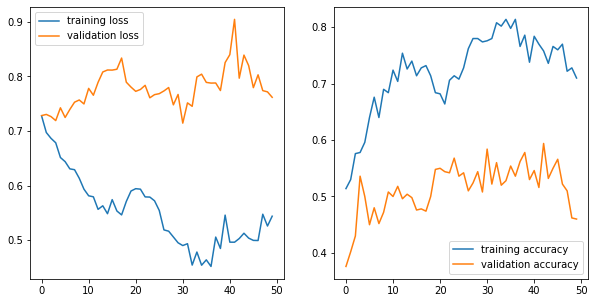

In [21]:
draw_history(history)

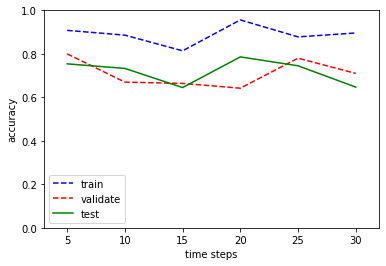

In [ ]:
# new model
# history = model.fit(train_ds, validation_data=validate_ds, epochs=50, steps_per_epoch = 500, batch_size = 50, validation_steps = 500, verbose=1)
# ps <-  5 tr_acc = 0.908, valacc = .8, te_acc = 0.754
# ps <- 10 tr_acc = 0.886, valacc = .67, te_acc = .733
# ps <- 15 tr_acc = 0.814, valacc = .664, te_acc = .645
# ps <- 20 tr_acc = 0.956, valacc = .642, te_acc = .786
# ps <- 25 tr_acc = 0.878, valacc = .78, te_acc = .745 --> would have been better at fewer epochs
# ps <- 30 tr_acc = 0.896, valacc = 0.71, te_acc = .647 --> reaches plateau much faster


plt.plot([5, 10, 15, 20, 25, 30], [0.908, 0.886, 0.814, 0.956, 0.878, 0.896], 'b--', label='train')
plt.plot([5, 10, 15, 20, 25, 30], [0.8, 0.67, 0.664, 0.642, 0.78, 0.71], 'r--', label='validate')
plt.plot([5, 10, 15, 20, 25, 30], [0.754, 0.733, 0.645, 0.786, 0.745, 0.647], 'g-', label='test')
plt.legend(['train', 'validate', 'test'])
plt.axis([3, 32, 0, 1])
plt.xlabel('time steps') 
plt.ylabel('accuracy')
plt.show()
